In [1]:
import os
import cv2
import glob
import h5py
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
from utils import get_density_map_gaussian
import matplotlib.pyplot as plt
%matplotlib inline


with_direction = False

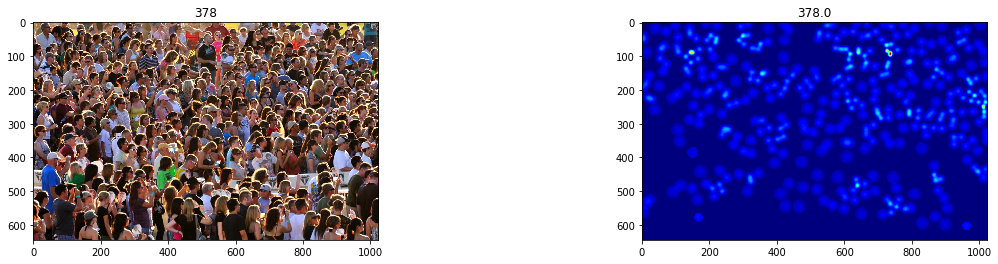

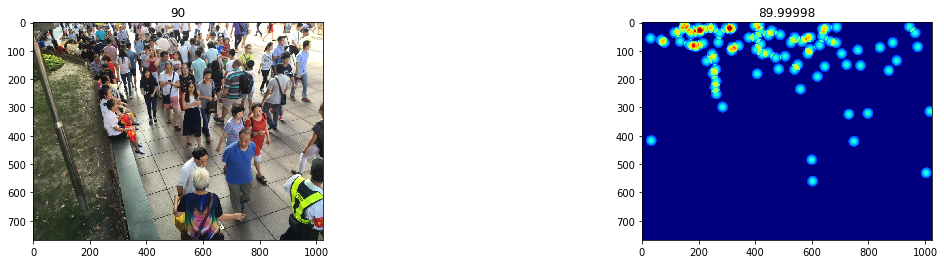

In [4]:
# Show a sample
img_paths = ['part_A/train_data/images/IMG_14.jpg',
             'part_B/train_data/images/IMG_20.jpg']
from utils import load_img
is_adaptive = False
for img_path in img_paths:
    is_adaptive = not is_adaptive
    img_ori = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    pts = loadmat(img_path.replace('.jpg', '.mat').replace('images', 'ground-truth').replace('IMG_', 'GT_IMG_'))
    img = cv2.imread(img_path)

    k = np.zeros((img.shape[0], img.shape[1]))

    gt = pts["image_info"][0, 0][0, 0][0]

    for i in range(len(gt)):
        if int(gt[i][1]) < img.shape[0] and int(gt[i][0]) < img.shape[1]:
            k[int(gt[i][1]), int(gt[i][0])] = 1

    k = get_density_map_gaussian(k, gt, adaptive_mode=is_adaptive)

    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 4))
    ax0.imshow(img_ori)
    ax0.set_title(str(gt.shape[0]))
    ax1.imshow(np.squeeze(k), cmap=plt.cm.jet)
    ax1.set_title(str(np.sum(k)))
    plt.show()